# Datamining on Stroke Dataset


This dataset contains information about 5110 people and their health in regards to their stroke history. There are 11 features (including the id) in the dataset which we will use to create models to predict whether or not someone is prone to stroke. These features include:


*   Gender
*   Age
*   Hypertension (known as high blood pressure, or a blood pressure above 140/90)
*   Heart Disease
*   Marital History (if the subject is or was ever married)
*   Type of Work (Government, Private, Self-Employed, Never Worked, or Children)
*   Residency (Rural or Urban)
*   Average Glucose Level
*   BMI
*   Smoking History (Smokes, Formally Smoked, Never Smoked or Unknown)

We wanted to be able to accurately predict whether someone is prone to having a stroke in the future based on these features. If we were able to accurately predict signs of a stroke, it could become extremely valuable to the medical field. Modeling this data could help hospitals and doctors detect those prone to stroke and begin treating or warning their patients of possible strokes in the future. However, we must create a model first, and that requires us to preprocess our data. 

In [556]:
# Standard imports
import warnings
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time

## Data Preprocessing (Exploration and Cleaning)

In [557]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Here, we want to remove the id column of our data, since it provides us no use to the model we want to create.

In [558]:
data.drop('id', axis=1, inplace=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Now that the id column is removed, we want to one-hot encode the data so it can be used in the models.

**One-Hot Encoding**


Since the non-binary categorical features are hard to extract data from, we use one-hot encoding to simplify this. These features include gender, marriage, work, residency, and smoking history.

In [559]:
hot_data = data.copy()
categorical_columns = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

for c in categorical_columns:
    vals = hot_data[c].unique()
    for v in vals:
        hot_data[f"{c}_{v}"] = hot_data[c].apply(lambda c_val: 1 if c_val == v else 0)
    hot_data.drop(c, axis=1, inplace=True)
print(hot_data.shape)
hot_data.head()

(5110, 22)


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Female,gender_Other,ever_married_Yes,ever_married_No,work_type_Private,work_type_Self-employed,work_type_Govt_job,work_type_children,work_type_Never_worked,Residence_type_Urban,Residence_type_Rural,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown
0,67.0,0,1,228.69,36.6,1,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
1,61.0,0,0,202.21,NaN,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0
2,80.0,0,1,105.92,32.5,1,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0
3,49.0,0,0,171.23,34.4,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0
4,79.0,1,0,174.12,24.0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0


**Data Cleaning (missing value detection)**


Now we want to check for any missing values in the data.

In [560]:
# Check for null values in every column
missing_gender = data['gender'].isnull().sum()
print("# of missing gender values: ", missing_gender)

missing_age = data['age'].isnull().sum()
print("# of missing age values: ", missing_age)

missing_hypertension = data['hypertension'].isnull().sum()
print("# of missing hypertension values: ", missing_hypertension)

missing_heart_disease = data['heart_disease'].isnull().sum()
print("# of missing heart_disease values: ", missing_heart_disease)

missing_ever_married = data['ever_married'].isnull().sum()
print("# of missing ever_married values: ", missing_ever_married)

missing_work_type = data['work_type'].isnull().sum()
print("# of missing work_type values: ", missing_work_type)

missing_Residence_type = data['Residence_type'].isnull().sum()
print("# of missing Residence_type values: ", missing_Residence_type)

missing_avg_glucose_level = data['avg_glucose_level'].isnull().sum()
print("# of missing avg_glucose_level values: ", missing_avg_glucose_level)

missing_bmi = data['bmi'].isnull().sum()
print("# of missing bmi values: ", missing_bmi)

missing_smoking_status = data['smoking_status'].isnull().sum()
print("# of missing smoking_status values: ", missing_smoking_status)

missing_stroke = data['stroke'].isnull().sum()
print("# of missing stroke values: ", missing_stroke)

# of missing gender values:  0
# of missing age values:  0
# of missing hypertension values:  0
# of missing heart_disease values:  0
# of missing ever_married values:  0
# of missing work_type values:  0
# of missing Residence_type values:  0
# of missing avg_glucose_level values:  0
# of missing bmi values:  201
# of missing smoking_status values:  0
# of missing stroke values:  0


We see that there are only missing data values for BMI, so we decide to check how large the proportion of missing values to the positive case of strokes compared to the overall distribution.

In [561]:
stroke_dist = len(hot_data[hot_data['stroke']==1].index)/len(hot_data.index)
null_bmi = hot_data[hot_data['bmi'].isnull()]
null_stroke_dist = len(null_bmi[null_bmi['stroke']==1].index)/len(null_bmi.index)
print('Percent of patients that experienced stroke:', stroke_dist)
print('Percent of patients without a measured BMI that experienced stroke:', null_stroke_dist)

Percent of patients that experienced stroke: 0.0487279843444227
Percent of patients without a measured BMI that experienced stroke: 0.19900497512437812


We can see that there are NaN values for BMI, here we chose to use imputation to clean the data. We choose to use imputation over a deletion method because we believe this would introduce less bias. We see that the proportion of missing values is greater in the positive case (i.e., had a stroke) compared to the general distribution of data. This would make list wise deletion introduce bias and remove samples at a greater proportion for the positive case. One problem with using univariate imputation is that BMI is highly variable and the distribution of data could still introduce bias. Here we choose to use multivariate imputation to attempt to address this problem.

In [562]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
hot_data = pd.DataFrame(imp.fit_transform(hot_data), columns=list(hot_data.columns))
hot_data

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Female,gender_Other,ever_married_Yes,ever_married_No,work_type_Private,work_type_Self-employed,work_type_Govt_job,work_type_children,work_type_Never_worked,Residence_type_Urban,Residence_type_Rural,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown
0,67.0,0.0,1.0,228.69,36.600000,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,61.0,0.0,0.0,202.21,31.171222,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,80.0,0.0,1.0,105.92,32.500000,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,49.0,0.0,0.0,171.23,34.400000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,79.0,1.0,0.0,174.12,24.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1.0,0.0,83.75,32.263355,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5106,81.0,0.0,0.0,125.20,40.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5107,35.0,0.0,0.0,82.99,30.600000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5108,51.0,0.0,0.0,166.29,25.600000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


Now that we have filled in our missing values, we will now standardize all of the numerical data.

In [563]:
# Standardize the age, avg_glucose_level, and bmi columns
numerical_cols = ["age", "avg_glucose_level", "bmi"]
for c in numerical_cols:
    hot_data[c] = (hot_data[c] - hot_data[c].mean()) / hot_data[c].std()
    
hot_data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Female,gender_Other,ever_married_Yes,ever_married_No,work_type_Private,work_type_Self-employed,work_type_Govt_job,work_type_children,work_type_Never_worked,Residence_type_Urban,Residence_type_Rural,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown
0,1.051331,0.0,1.0,2.706111,0.990957,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.785993,0.0,0.0,2.121351,0.288746,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.626231,0.0,1.0,-0.005028,0.460623,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.255317,0.0,0.0,1.437217,0.706388,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.582008,1.0,0.0,1.501038,-0.638849,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


For all of our numerical data, we created boxplots to see the mean and quartile ranges for each feature. We also looked for any outliers to remove.

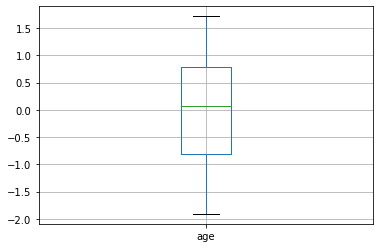

In [564]:
# Boxplot for age
hot_data.boxplot(column=['age'])

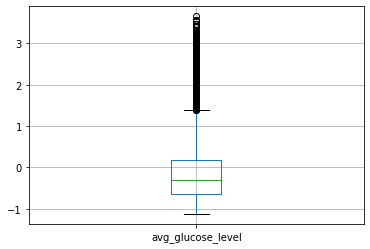

In [565]:
# Boxplot for glucode level
hot_data.boxplot(column=['avg_glucose_level'])

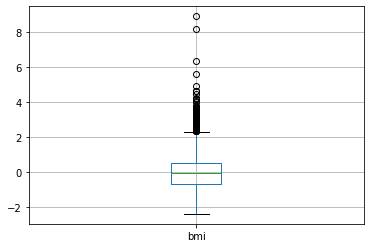

In [566]:
# Boxplot for BMI
hot_data.boxplot(column=['bmi'])

Create bar charts for all categorical data

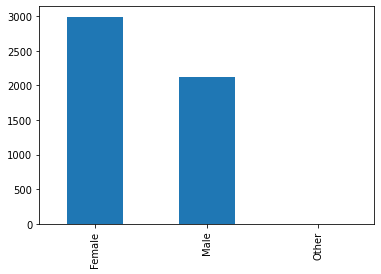

In [567]:
# Bar chart for gender counts
data["gender"].value_counts().plot(kind='bar')

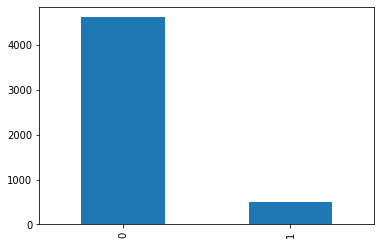

In [568]:
# Bar chart for hypertension counts
data["hypertension"].value_counts().plot(kind='bar')

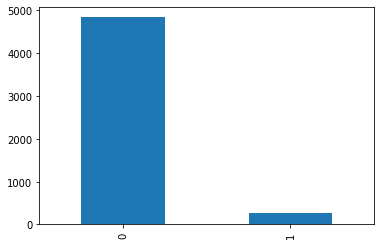

In [569]:
# Bar chart for heart_disease counts
data["heart_disease"].value_counts().plot(kind='bar')

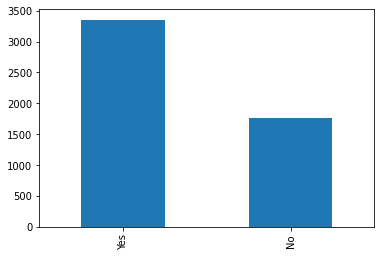

In [570]:
# Bar chart for ever_married counts
data["ever_married"].value_counts().plot(kind='bar')

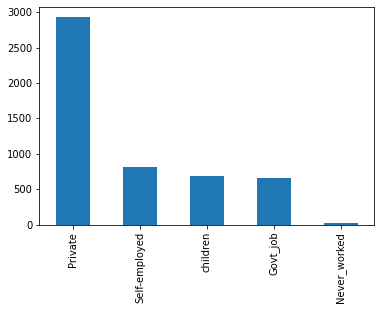

In [571]:
# Bar chart for work_type counts
data["work_type"].value_counts().plot(kind='bar')

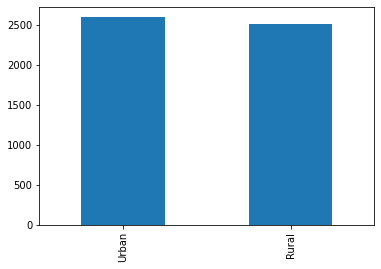

In [572]:
# Bar chart for Residence_type counts
data["Residence_type"].value_counts().plot(kind='bar')

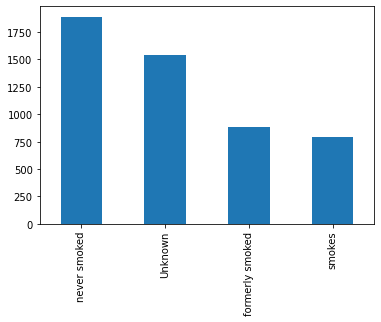

In [573]:
# Bar chart for smoking_status counts
data["smoking_status"].value_counts().plot(kind='bar')

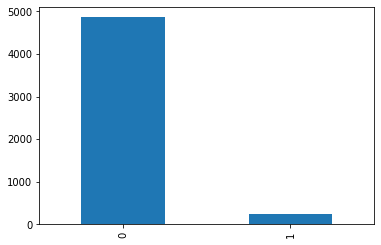

In [574]:
# Bar chart for stroke counts
data["stroke"].value_counts().plot(kind='bar')

Since we only detected outliers in the Average Glucose Levels and BMI, we promptly remove those data points from our data.

In [575]:
# Remove some outliers

# From average glucose level
hot_data = hot_data[(np.abs(stats.zscore(hot_data["avg_glucose_level"])) < 3)]

# From BMI
hot_data = hot_data[(np.abs(stats.zscore(hot_data["bmi"])) < 3)]

print(f"New hot_dataset shape: {hot_data.shape}")
hot_data.head()

New hot_dataset shape: (5002, 22)


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Female,gender_Other,ever_married_Yes,ever_married_No,work_type_Private,work_type_Self-employed,work_type_Govt_job,work_type_children,work_type_Never_worked,Residence_type_Urban,Residence_type_Rural,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown
0,1.051331,0.0,1.0,2.706111,0.990957,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.785993,0.0,0.0,2.121351,0.288746,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.626231,0.0,1.0,-0.005028,0.460623,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.255317,0.0,0.0,1.437217,0.706388,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.582008,1.0,0.0,1.501038,-0.638849,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Feature Engineering

Now that we have cleaned the data, we perform feature engineering to select useful features to use to build our models. In the histograms shown below, the orange displays the data that has had a stroke, while the blue shows the data that has not.

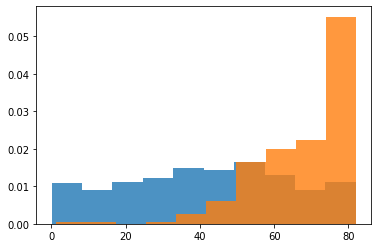

In [576]:
stroke = data[data['stroke'] == 1]
no_stroke = data[data['stroke']==0]

plt.hist(no_stroke['age'], density=True, alpha=0.8)
plt.hist(stroke['age'], density=True, alpha=0.8)

plt.show()

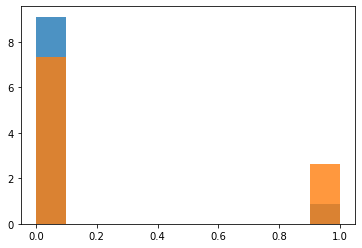

In [577]:
plt.hist(no_stroke['hypertension'], density=True, alpha=0.8)
plt.hist(stroke['hypertension'], density=True, alpha=0.8)

plt.show()

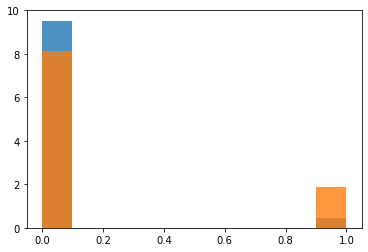

In [578]:
plt.hist(no_stroke['heart_disease'], density=True, alpha=0.8)
plt.hist(stroke['heart_disease'], density=True, alpha=0.8)

plt.show()

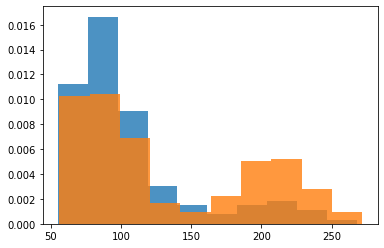

In [579]:
plt.hist(no_stroke['avg_glucose_level'], density=True, alpha=0.8)
plt.hist(stroke['avg_glucose_level'], density=True, alpha=0.8)

plt.show()

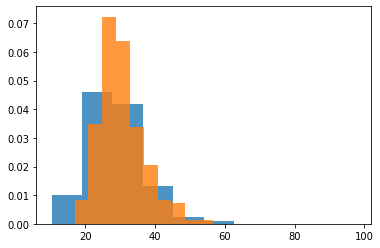

In [580]:
plt.hist(no_stroke['bmi'], density=True, alpha=0.8)
plt.hist(stroke['bmi'], density=True, alpha=0.8)

plt.show()

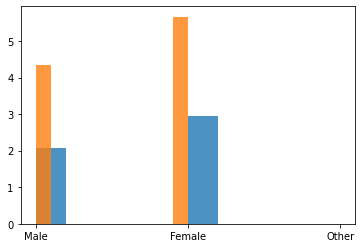

In [581]:
plt.hist(no_stroke['gender'], density=True, alpha=0.8)
plt.hist(stroke['gender'], density=True, alpha=0.8)

plt.show()

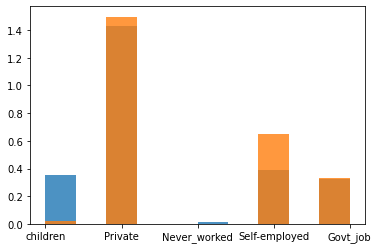

In [582]:
plt.hist(no_stroke['work_type'], density=True, alpha=0.8)
plt.hist(stroke['work_type'], density=True, alpha=0.8)

plt.show()

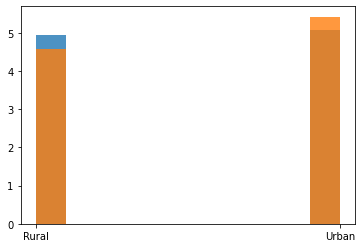

In [583]:
plt.hist(no_stroke['Residence_type'], density=True, alpha=0.8)
plt.hist(stroke['Residence_type'], density=True, alpha=0.8)

plt.show()

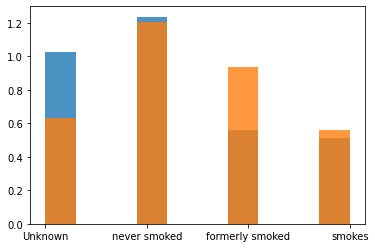

In [584]:
plt.hist(no_stroke['smoking_status'], density=True, alpha=0.8)
plt.hist(stroke['smoking_status'], density=True, alpha=0.8)

plt.show()

We can also visualize the correlations between features and the stroke class using a correlation matrix. We want to ensure that features are not highly correlated with each other because this means that they are redundant.

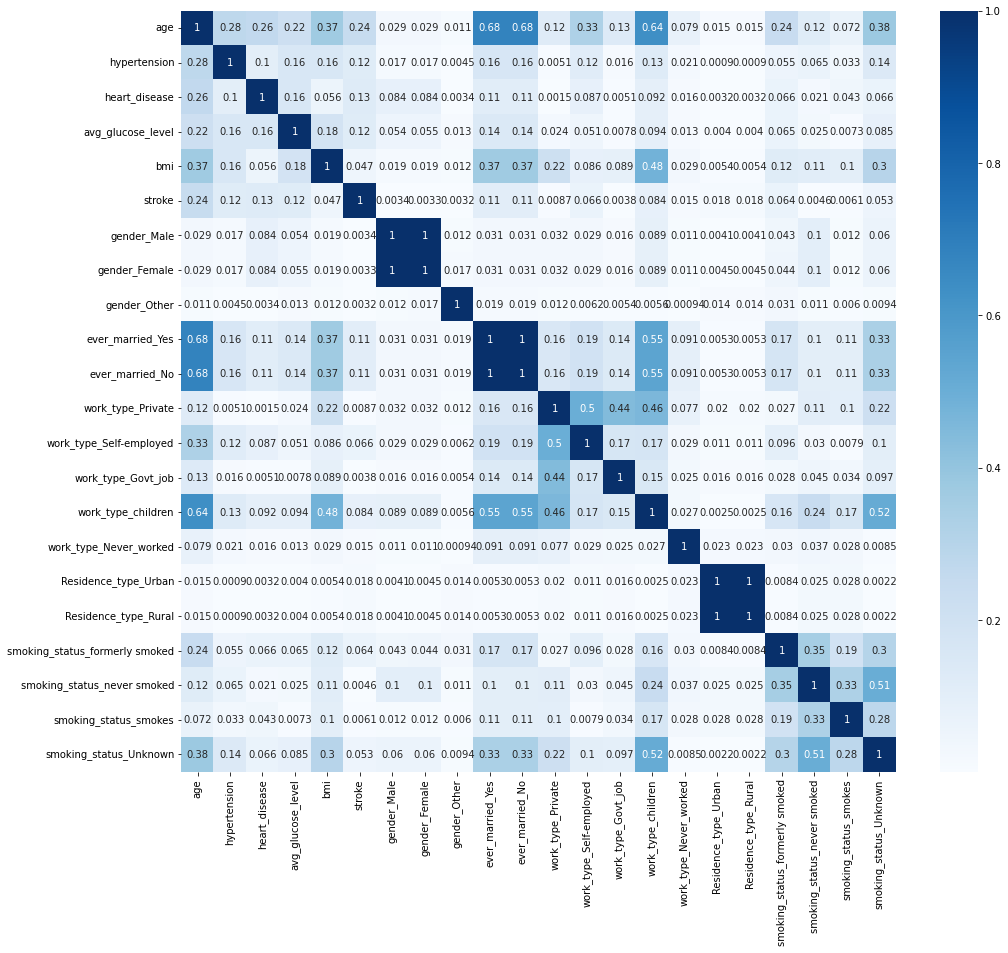

In [585]:
#Using Pearson Correlation
import seaborn as sns

plt.figure(figsize=(16, 14))
cor = hot_data.corr()
cor = abs(cor)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

This tells us that among these features, age is highly correlated with ever_married_No and with ever_married_Yes. work_type_children is similarly correlated. In addition, ever_married_No and ever_married_Yes are highly correlated. Therefore, we can remove all of ever_married_No, ever_married_Yes, and work_type_children because they are redundant when we have age. Lastly, Residence_type_Urban and Residence_type_Rural are highly correlated, as well as gender_Male and gender_Female so we will only keep one of each. This results in the following correlation matrix for the features to select.

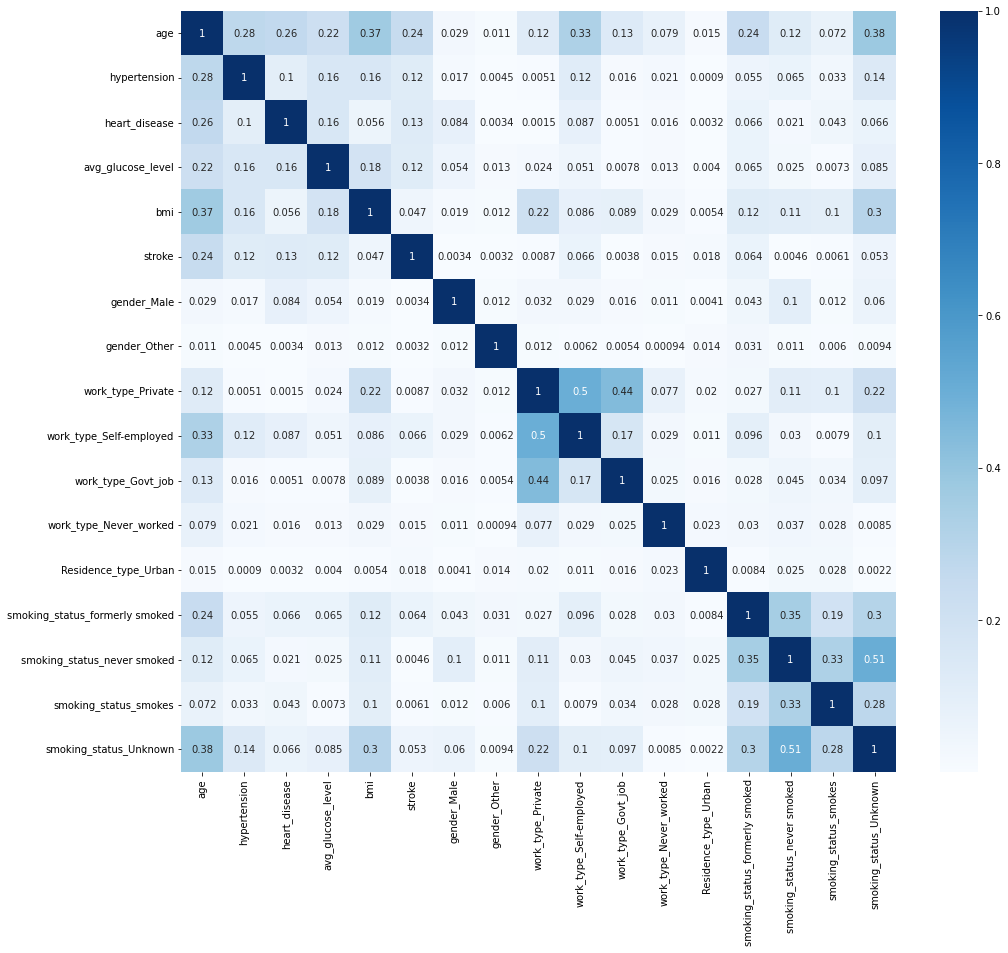

In [586]:
# remove features
relevant_features = cor["stroke"].copy()
del relevant_features["ever_married_No"]
del relevant_features["ever_married_Yes"]
del relevant_features["work_type_children"]
del relevant_features["Residence_type_Rural"]
del relevant_features["gender_Female"]

# build corr matrix
plt.figure(figsize=(16, 14))
relevant_cor = hot_data[relevant_features.index].corr()
relevant_cor = abs(relevant_cor)
sns.heatmap(relevant_cor, annot=True, cmap=plt.cm.Blues)
plt.show()

Now we update our hot_data to only use these selected features.

In [587]:
# update hot_data
original_hot_data = hot_data.copy()
hot_data = hot_data[relevant_features.index]
hot_data

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,work_type_Private,work_type_Self-employed,work_type_Govt_job,work_type_Never_worked,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown
0,1.051331,0.0,1.0,2.706111,0.990957,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.785993,0.0,0.0,2.121351,0.288746,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.626231,0.0,1.0,-0.005028,0.460623,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.255317,0.0,0.0,1.437217,0.706388,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.582008,1.0,0.0,1.501038,-0.638849,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.626231,1.0,0.0,-0.494609,0.430013,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5106,1.670454,0.0,0.0,0.420734,1.430746,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5107,-0.363806,0.0,0.0,-0.511393,0.214859,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5108,0.343763,0.0,0.0,1.328127,-0.431890,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Data Mining (Testing Different Models)

In [588]:
# Separating labels from the rest of the data
data_Y = data['stroke']
data_X = data.drop(['stroke'], axis=1)

hot_data_Y = hot_data['stroke']
hot_data_X = hot_data.drop(['stroke'], axis=1)
print(hot_data_X.shape)
print(hot_data_Y.shape)

(5002, 16)
(5002,)


**Decision Trees**

In [589]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score

print("\nUsing criterion: Entropy")
clf = DecisionTreeClassifier(criterion='entropy')
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")

print("\nUsing criterion: Gini")
clf = DecisionTreeClassifier(criterion='gini')
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")

print("\nUsing criterion: max_depth of 10")
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10)
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")

print("\nUsing criterion: max_depth of 1")
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")

print("\nUsing criterion: min_samples_split = 20")
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=20)
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")

print("\nUsing criterion: min_samples_leaf = 10")
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")

print("\nUsing criterion: min_impurity_decrease = .9")
clf = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=.9)
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")


Using criterion: Entropy
Accuracy: 91.22343313373253

Using criterion: Gini
Accuracy: 91.10387225548904

Using criterion: max_depth of 10
Accuracy: 93.36259481037924

Using criterion: max_depth of 1
Accuracy: 95.22191616766466

Using criterion: min_samples_split = 20
Accuracy: 92.98283433133733

Using criterion: min_samples_leaf = 10
Accuracy: 92.22323353293413

Using criterion: min_impurity_decrease = .9
Accuracy: 95.22191616766466


So far, the best accuracy was produced by decreasing the max depth or using a min_impurity_decrease. We can further try more combinations using a GridSearchCV.

In [590]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

params = {
    "max_depth": [1, 3, 5, 10, 20], 
    "min_samples_split": [5, 10, 20], 
    "min_samples_leaf": [1, 3, 5, 10, 20], 
    "max_features": [1, 3, 5, 10, 15],
    "min_impurity_decrease": [.1, .3, .5, .9]}

grid_search = GridSearchCV(clf, params, cv=5, scoring="accuracy")
grid_search.fit(hot_data_X, hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'max_depth': 1, 'max_features': 1, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 95.22191808191808


In [591]:
preds = grid_search.predict(hot_data_X)
print("\nClassification Report:")
print(classification_report(hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      4763
         1.0       0.00      0.00      0.00       239

    accuracy                           0.95      5002
   macro avg       0.48      0.50      0.49      5002
weighted avg       0.91      0.95      0.93      5002



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The "best" decision tree simply chooses the "no stroke" label every almost every time, which produces a poor f-score. We can try to fix this by undersampling the majority class.

In [592]:
num_stroke = int(hot_data["stroke"].sum())
print(f"number of records with stroke: {num_stroke}")

# sample equally
balanced_hot_data = hot_data.groupby('stroke').apply(lambda x: x.sample(num_stroke))
balanced_hot_data_Y = balanced_hot_data['stroke']
balanced_hot_data_X = balanced_hot_data.drop(['stroke'], axis=1)
print(balanced_hot_data.shape)
balanced_hot_data.head()

number of records with stroke: 239
(478, 17)


age  ...  smoking_status_Unknown
stroke                 ...                        
0.0    3694 -0.673367  ...                     0.0
       1981 -0.054245  ...                     0.0
       1868  0.255317  ...                     1.0
       4033  0.830216  ...                     0.0
       350   1.582008  ...                     0.0

[5 rows x 17 columns]

In [593]:
# Generating another Decision Tree using balanced_hot_data
params = {
    "max_depth": [1, 3, 5, 10, 20], 
    "min_samples_split": [5, 10, 20], 
    "min_samples_leaf": [1, 3, 5, 10, 20], 
    "max_features": [1, 3, 5, 10, 15],
    "min_impurity_decrease": [.1, .3, .5, .9]}

grid_search = GridSearchCV(clf, params, cv=5, scoring="accuracy")
grid_search.fit(balanced_hot_data_X, balanced_hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'max_depth': 1, 'max_features': 10, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 5, 'min_samples_split': 5}
Accuracy: 75.31578947368422


In [594]:
preds = grid_search.predict(balanced_hot_data_X)
print("\nClassification Report:")
print(classification_report(balanced_hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.58      0.71       239
         1.0       0.69      0.94      0.80       239

    accuracy                           0.76       478
   macro avg       0.80      0.76      0.75       478
weighted avg       0.80      0.76      0.75       478



The average f-score is greatly improved now! However, we only have a 75% accuracy.

**Naive Bayes**

In [595]:
from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

# Use a gaussian Naive Bayes with 10-fold cross validation
gnb = GaussianNB()
preds = cross_val_predict(gnb, balanced_hot_data_X, balanced_hot_data_Y, cv=10)
print("\nClassification Report:")
print(classification_report(balanced_hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.26      0.40       239
         1.0       0.57      0.97      0.71       239

    accuracy                           0.61       478
   macro avg       0.73      0.61      0.56       478
weighted avg       0.73      0.61      0.56       478



Standard gaussian Naive Bayes produces a lower accuracy and f-score compared to the decision tree.

**K-Nearest Neighbors**


Since KNN suffers from the curse of dimensionality, we will have to perform dimensionality reduction. We use a GridSearchCV to perform hyperparamter tuning.

In [596]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

pca = PCA()
knn = KNeighborsClassifier(n_neighbors=7)
pline = Pipeline(steps=[("pca", pca), ("knn", knn)])

param_grid = {
    'pca__n_components': list(range(3, 15, 3)),
    'knn__n_neighbors': list(range(1, 25))
}

grid_search = GridSearchCV(pline, param_grid, cv=5, scoring="accuracy")
grid_search.fit(hot_data_X, hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'knn__n_neighbors': 10, 'pca__n_components': 6}
Accuracy: 95.22191808191808


In [597]:
preds = grid_search.predict(hot_data_X)
print("\nClassification Report:")
print(classification_report(hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      4763
         1.0       0.00      0.00      0.00       239

    accuracy                           0.95      5002
   macro avg       0.48      0.50      0.49      5002
weighted avg       0.91      0.95      0.93      5002



Again, this produces a poor f-score so we will try again on the balanced one-hot-encoded dataset

In [598]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

grid_search.fit(balanced_hot_data_X, balanced_hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'knn__n_neighbors': 10, 'pca__n_components': 3}
Accuracy: 75.29166666666667


In [599]:
preds = grid_search.predict(balanced_hot_data_X)
print("\nClassification Report:")
print(classification_report(balanced_hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76       239
         1.0       0.76      0.79      0.78       239

    accuracy                           0.77       478
   macro avg       0.77      0.77      0.77       478
weighted avg       0.77      0.77      0.77       478



This model appears to be more successful than the one built using a decision tree.

**Support Vector Machines**

We again use a GridSearchCV to perform hyperparamter tuning. We will also use the balanced one-hot-encoded dataset.

In [600]:
from sklearn.svm import SVC

pca = PCA()
svc = SVC()
pline = Pipeline(steps=[("pca", pca), ("svc", svc)])

param_grid = {
    'pca__n_components': list(range(3, 15, 3)),
    'svc__kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(pline, param_grid, cv=5, scoring="accuracy")
grid_search.fit(balanced_hot_data_X, balanced_hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'pca__n_components': 9, 'svc__kernel': 'linear'}
Accuracy: 76.76315789473685


In [601]:
preds = grid_search.predict(balanced_hot_data_X)
print("\nClassification Report:")
print(classification_report(balanced_hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.70      0.76       239
         1.0       0.74      0.85      0.79       239

    accuracy                           0.78       478
   macro avg       0.78      0.78      0.77       478
weighted avg       0.78      0.78      0.77       478



This SVM model appears to perform even better than KNN, running faster and producing a higher f-score.

**Random Forests**

In [602]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
param_grid = {
    'max_depth': list(range(5, 61, 5)),
    'min_samples_leaf': [2, 31, 4],
    'max_features': ["sqrt", "log2"]
}

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring="accuracy")
grid_search.fit(balanced_hot_data_X, balanced_hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 31}
Accuracy: 76.35526315789474


In [603]:
preds = grid_search.predict(balanced_hot_data_X)
print("\nClassification Report:")
print(classification_report(balanced_hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.65      0.74       239
         1.0       0.72      0.90      0.80       239

    accuracy                           0.77       478
   macro avg       0.79      0.77      0.77       478
weighted avg       0.79      0.77      0.77       478



Since Random Forests don't suffer from the curse of dimensionality, let's try it with all features. Again, first we undersample the majority class.

In [604]:
num_stroke = int(original_hot_data["stroke"].sum())
print(f"number of records with stroke: {num_stroke}")

# sample equally
balanced_original_hot_data = original_hot_data.groupby('stroke').apply(lambda x: x.sample(num_stroke))
balanced_original_hot_data_Y = balanced_original_hot_data['stroke']
balanced_original_hot_data_X = balanced_original_hot_data.drop(['stroke'], axis=1)
print(balanced_original_hot_data.shape)
balanced_original_hot_data.head()

number of records with stroke: 239
(478, 22)


age  ...  smoking_status_Unknown
stroke                 ...                        
0.0    2912 -0.761813  ...                     0.0
       3459  0.697547  ...                     0.0
       355   1.007108  ...                     0.0
       1953  1.272447  ...                     0.0
       1744 -1.204044  ...                     0.0

[5 rows x 22 columns]

In [605]:
rfc = RandomForestClassifier()
param_grid = {
    'max_depth': list(range(5, 61, 5)),
    'min_samples_leaf': [2, 31, 4],
    'max_features': ["sqrt", "log2"]
}

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring="accuracy")
grid_search.fit(balanced_original_hot_data_X, balanced_original_hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4}
Accuracy: 80.32894736842104


In [606]:
preds = grid_search.predict(balanced_original_hot_data_X)
print("\nClassification Report:")
print(classification_report(balanced_original_hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86       239
         1.0       0.83      0.91      0.87       239

    accuracy                           0.86       478
   macro avg       0.87      0.86      0.86       478
weighted avg       0.87      0.86      0.86       478



Random Forests produce the best f-score and accuracy by far, with an f-score of 0.86!